### Variational Autoencoder

#### References
- [DCGAN in Keras](https://keras.io/examples/generative/dcgan_overriding_train_step/)

<a href="https://colab.research.google.com/github/paulaceccon/dl-from-scratch/blob/main/name.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Layer, Reshape
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Mean

%load_ext tensorboard

### Load the dataset

In [ ]:
def preprocess(data: np.array) -> np.ndarray:
    data = data.astype("float32") / 255.0
    data = np.reshape(data, (len(data), 28, 28, 1))
    return data

In [ ]:
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Visualization

In [ ]:
def plot_latent_distribution(vae: Model, data: np.ndarray, labels: np.ndarray) -> None:
    plt.figure(figsize=(6, 6))
    z_mean, _, _ = vae.encoder.predict(data)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()

In [ ]:
def plot_latent_space(vae: Model, n_samples: int = 15):
    # Display a 2D manifold of the digits
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n_samples, digit_size * n_samples))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n_samples)
    grid_y = np.linspace(-scale, scale, n_samples)[::-1]

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="Greys_r")

### Model

In an autoencoder, each image is mapped directly to one point in the latent space. In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in the latent space.

![image](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)

Quoting the explanation depict in the book [Avanced Machine Learning with Python](https://www.amazon.com.br/Advanced-Deep-Learning-Python-Vasilev/dp/178995617X):

> The goal of the encoder is to approximate the real probability distribution, $p(\mathbf{z})$, where $\mathbf{z}$ is the latent space representation. However, it does so indirectly by inferring $p(\mathbf{z})$ from the conditional probability distribution of various samples, $p(\mathbf{z}|\mathbf{x})$, where $\mathbf{x}$ is the input data. In other words, the encoder tries to learn the probability distribution of $\mathbf{z}$, given the input data, $\mathbf{x}$. We'll denote the encoder's approximation of $p(\mathbf{z}|\mathbf{x})$ with $q_{\phi}(\mathbf{z}|\mathbf{x})$, where $\phi$ are the weights of the network. The encoder output is a probability distribution (for example, Gaussian) over the possible values of $\mathbf{z}$, which could have been generated by $\mathbf{x}$. During training, we continuously update the weights, $\phi$, to bring  closer to the real $P(\mathbf{z}|\mathbf{x})$.

> The goal of the decoder is to approximate the real probability distribution, $p(\mathbf{x}|\mathbf{z})$. In other words, the decoder tries to learn the conditional probability distribution of the data, $\mathbf{x}$, given the latent representation, $\mathbf{z}$. We'll denote the decoder's approximation of the real probability distribution with $p_{\theta}(\mathbf{x}|\mathbf{z})$, where $\theta$ is the decoder weights. The process starts by sampling $\mathbf{z}$ stochastically (randomly) from the probability distribution (for example, Gaussian). Then, $\mathbf{z}$ is sent through the decoder, whose output is a probability distribution over the possible corresponding values of $\mathbf{x}$. During training, we continuously update the weights, $\theta$, to bring $p_{\theta}(\mathbf{x}|\mathbf{z})$ closer to the real $p(\mathbf{x}|\mathbf{z})$.

![image](https://miro.medium.com/max/1400/1*6uuK7GpIbfTb-0chqFwXXw.png)

In [ ]:
class Sampling(Layer):
    """
    Uses (z_mean, z_log_var) to sample z, i.e.,
    to encode an image into a specific point z in the latent space.
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]  # mini-batch size
        dim = tf.shape(z_mean)[1]  # latent space size
        epsilon = tf.keras.backend.random_normal(
            shape=(batch, dim)
        )  # random normal vector with mean=0 and std=1.0
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def build_encoder(latent_dim: int = 2) -> Model:
    """
    The encoder will take each input image and encode it to two vectors,
    z_mean and z_log_var, which together define a multivariate
    normal distribution in the latent space.
    """
    encoder_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()

    return encoder

In [ ]:
def build_decoder(latent_dim: int = 2) -> Model:
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    return decoder

In [ ]:
class VAE(Model):
    """Implements a variational autoencoder."""

    def __init__(self, encoder: Model, decoder: Model, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            # reconstruction loss
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            # kullback-leibler divergence
            # (lost information, how much one probability differs from the other)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(binary_crossentropy(data, reconstruction))
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

### Training

In [ ]:
def train_model(train_data: np.ndarray, test_data: np.ndarray) -> VAE:
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder, decoder)
    vae.compile(optimizer="adam")
    vae.fit(
        train_data,
        epochs=100,
        batch_size=128,
        shuffle=True,
        validation_data=(test_data,),
        verbose=0,
        callbacks=[EarlyStopping(patience=5), tensorboard_callback],
    )
    return vae

In [ ]:
%tensorboard --logdir logs

In [ ]:
vae = train_model(x_train, x_test)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

2022-04-01 16:48:21.224136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


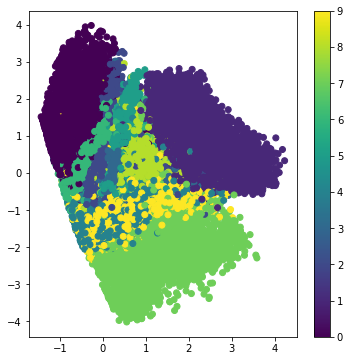

In [ ]:
plot_latent_distribution(vae, x_train, y_train)

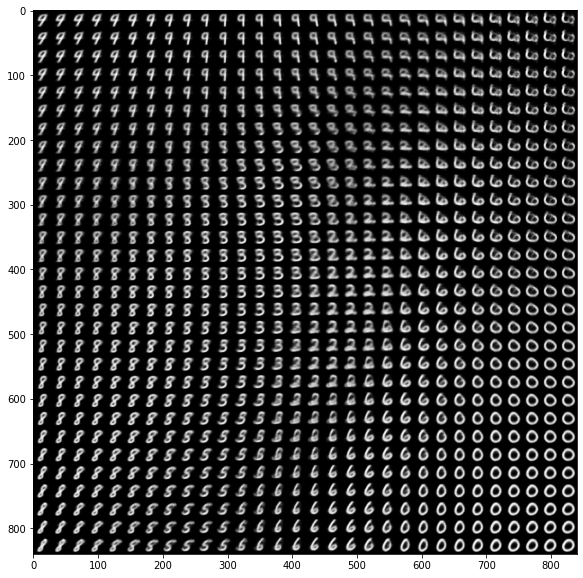

In [ ]:
plot_latent_space(vae, n_samples=30)